In [ ]:
import readfcs
import pandas as pd
import numpy as np
import os
import re

In [ ]:
import os
import re
from pathlib import Path
from typing import Dict, Union, List

import readfcs
import pandas as pd
import numpy as np


def compare_fcs_lengths(original_dir: Union[str, Path], target_dir: Union[str, Path]) -> pd.DataFrame:
    """Compares the event counts of FCS files in an original directory against
    corresponding files in a target directory using readfcs.

    This function identifies corresponding files by extracting the first 4-digit
    identifier from the filenames in the original directory and finding filenames
    in the target directory that contain the same identifier.

    Args:
        original_dir (Union[str, Path]): Path to the directory containing the
            original FCS files.
        target_dir (Union[str, Path]): Path to the directory containing the
            target FCS files for comparison.

    Returns:
        pd.DataFrame: A pandas DataFrame with the following columns:
            - 'original_file': The name of the file from the original directory.
            - 'target_file': The name of the corresponding file from the
              target directory.
            - 'original_events': The number of events in the original file.
            - 'target_events': The number of events in the target file.
            - 'event_difference': The absolute difference in event counts.
            - 'percentage_reduction': The reduction in events as a percentage
              of the original count.
            - 'status': The status of the comparison (e.g., 'Success',
              'Target not found', 'Error').
    """
    original_path = Path(original_dir)
    target_path = Path(target_dir)
    results = []

    if not original_path.is_dir():
        raise FileNotFoundError(f"Original directory not found: {original_path}")
    if not target_path.is_dir():
        raise FileNotFoundError(f"Target directory not found: {target_path}")

    target_files = {f.name for f in target_path.glob('*.fcs')}

    for original_filepath in original_path.glob('*.fcs'):
        original_filename = original_filepath.name
        match = re.search(r'(\d{4})', original_filename)

        identifier = match.group(1)
        found_target_filename = next((fname for fname in target_files if identifier in fname), None)
        
        target_filepath = target_path / found_target_filename

        adata_original = readfcs.read(str(original_filepath))
        original_length = adata_original.n_obs

        adata_target = readfcs.read(str(target_filepath))
        target_length = adata_target.n_obs

        difference = original_length - target_length
        percentage_reduction = (difference / original_length) * 100 if original_length > 0 else 0
        print(
            f"Original file {original_filename} has {original_length} events \n target file {found_target_filename} has {target_length} events \n difference is {difference}, percentage reduction is {percentage_reduction}")

        results.append({
            'original_file': original_filename,
            'target_file': found_target_filename,
            'original_events': original_length,
            'target_events': target_length,
            'event_difference': difference,
            'percentage_reduction': percentage_reduction,
            'status': 'Success'
        })

    return pd.DataFrame(results)

In [3]:
root = r"Y:/g/data/eu59/data_flowmop/fig_4_data/heuvue/"

In [4]:
directory_dict = {
    'test_flowcut' : ('test', 'flowcut'),
    'test_peacoqc' : ('test', 'peacoqc'),
    'test_flowmop_individualfilters/debrispass' : ('test', 'flowmop_debris'),
    'test_flowmop_individualfilters/doubletpass' : ('test', 'flowmop_doublet'),
    'test_flowmop_individualfilters/timepass' : ('test', 'flowmop_time'),
    'test_flowmop_individualfilters/passfiltered' : ('test', 'flowmop_full'),
    'train_flowcut' : ('train', 'flowcut'),
    'train_peacoqc' : ('train', 'peacoqc'),
    'train_flowmop_individualfilters/debrispass' : ('train', 'flowmop_debris'),
    'train_flowmop_individualfilters/doubletpass' : ('train', 'flowmop_doublet'),
    'train_flowmop_individualfilters/timepass' : ('train', 'flowmop_time'),
    'train_flowmop_individualfilters/passfiltered' : ('train', 'flowmop_full'),
}


In [5]:
results = []
for key, value in directory_dict.items():
    test_train = value[0]
    cleanmethod = value[1]
    result = compare_fcs_lengths(root + test_train, root + key)
    result['cleanmethod'] = cleanmethod
    result['test_train'] = test_train
    results.append(result)

Original file 0280.FCS has 44630 events 
 target file 0280_flowcut.fcs has 43418 events 
 difference is 1212, percentage reduction is 2.7156621106878784
Original file 0267.FCS has 500000 events 
 target file 0267_flowcut.fcs has 489000 events 
 difference is 11000, percentage reduction is 2.1999999999999997
Original file 0235.FCS has 295191 events 
 target file 0235_flowcut.fcs has 277191 events 
 difference is 18000, percentage reduction is 6.0977468825269066
Original file 0301.FCS has 114591 events 
 target file 0301_flowcut.fcs has 110895 events 
 difference is 3696, percentage reduction is 3.225384192475849
Original file 0069.FCS has 397683 events 
 target file 0069_flowcut.fcs has 376183 events 
 difference is 21500, percentage reduction is 5.406316085927736
Original file 0240.FCS has 436158 events 
 target file 0240_flowcut.fcs has 416158 events 
 difference is 20000, percentage reduction is 4.585494247497467
Original file 0228.FCS has 347112 events 
 target file 0228_flowcut.fcs

In [ ]:
cleaning_summary = pd.concat(results)
cleaning_summary.to_csv('heuvue_cleaning_summary.csv', index=False)

In [20]:
os.chdir("C:/Users/Tony/Documents/github_remotes/FlowMOP/flowmop_paper_analysis_code/fig_4_csv_analysis")

cleaning_summary = pd.read_csv("C:/Users/Tony/Documents/github_remotes/FlowMOP/figs/fig_4_data/heuvue_cleaning_summary.csv")

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Set
from scipy import stats

def plot_percentage_reduction_with_stats(df: pd.DataFrame) -> None:
    """
    Plots the distribution of percentage reduction for each cleaning method, with test/train 
    status side-by-side. It performs a Mann-Whitney U test to compare test and train groups
    for each method and displays significance brackets for p < 0.05.

    Args:
        df (pd.DataFrame): DataFrame containing at least 'cleanmethod', 'percentage_reduction', 
                           and 'test_train' columns.

    Raises:
        ValueError: If required columns are missing.
    """
    required_cols: Set[str] = {'cleanmethod', 'percentage_reduction', 'test_train'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    # Define the desired order for cleaning methods
    flowmop_order = [
        'flowmop_full', 'flowmop_debris', 'flowmop_time', 'flowmop_doublet'
    ]
    other_methods = ['flowcut', 'peacoqc']
    present_methods = df['cleanmethod'].unique().tolist()
    ordered_methods = [m for m in flowmop_order if m in present_methods] + \
                      [m for m in other_methods if m in present_methods]
    if any(m not in ordered_methods for m in present_methods):
        ordered_methods.extend([m for m in present_methods if m not in ordered_methods])

    # --- 1. Statistical Analysis ---
    # Perform Mann-Whitney U test between test and train for each method
    p_values = {}
    for method in ordered_methods:
        method_df = df[df['cleanmethod'] == method]
        test_data = method_df[method_df['test_train'] == 'test']['percentage_reduction']
        train_data = method_df[method_df['test_train'] == 'train']['percentage_reduction']
        
        # Ensure there is data in both groups to compare
        if not test_data.empty and not train_data.empty:
            # Use mannwhitneyu for independent samples
            stat, p_val = stats.mannwhitneyu(test_data, train_data, alternative='two-sided')
            p_values[method] = p_val

    # --- 2. Plotting ---
    side_by_side_palette = {'test': '#40648A', 'train': '#55a868'}
    test_train_order = [val for val in ['test', 'train'] if val in df['test_train'].unique()]

    plt.style.use('seaborn-v0_8-ticks')
    fig, ax = plt.subplots(figsize=(max(8, len(ordered_methods) * 1.8), 7))

    sns.boxplot(
        x='cleanmethod', y='percentage_reduction', hue='test_train',
        data=df, order=ordered_methods, hue_order=test_train_order,
        palette=side_by_side_palette, ax=ax, showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 7}
    )

    # --- 3. Add Significance Annotations ---
    def add_significance_bracket(method_name: str, x_pos: int, p_val: float):
        """Draws a significance bracket between test and train bars for a method."""
        if p_val >= 0.05:
            return

        # Determine significance level
        if p_val < 0.001: s_text = '***'
        elif p_val < 0.01: s_text = '**'
        else: s_text = '*'
        
        # Get the highest point for the current method's boxes to position the bracket
        max_y = df[df['cleanmethod'] == method_name]['percentage_reduction'].max()
        
        # Positions for the bracket (dodged by hue)
        bar_width = 0.4 
        x1, x2 = x_pos - bar_width / 2, x_pos + bar_width / 2
        
        # Bracket position and height
        y_bracket = max_y + 0.05 * ax.get_ylim()[1]
        bracket_height = 0.02 * ax.get_ylim()[1]
        
        ax.plot([x1, x1, x2, x2], [y_bracket, y_bracket + bracket_height, y_bracket + bracket_height, y_bracket], c='k', lw=1.2)
        ax.text((x1 + x2) / 2, y_bracket + bracket_height, s_text, ha='center', va='bottom', fontsize=12, weight='bold')

    # Add annotations for each method with a significant p-value
    for i, method in enumerate(ordered_methods):
        if method in p_values:
            add_significance_bracket(method, i, p_values[method])

    # --- 4. Final Touches ---
    ax.set_title('Percentage Reduction by Method (Test vs. Train)', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Cleaning Method', fontsize=12, labelpad=15)
    ax.set_ylabel('Percentage Reduction (%)', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
    sns.despine(ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [label.capitalize() for label in labels], title="Set", loc="best", fontsize=10, title_fontsize=11)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_percentage_reduction_with_stats(cleaning_summary)

C:\Users\Tony\AppData\Local\Temp\ipykernel_14228\1758962018.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')


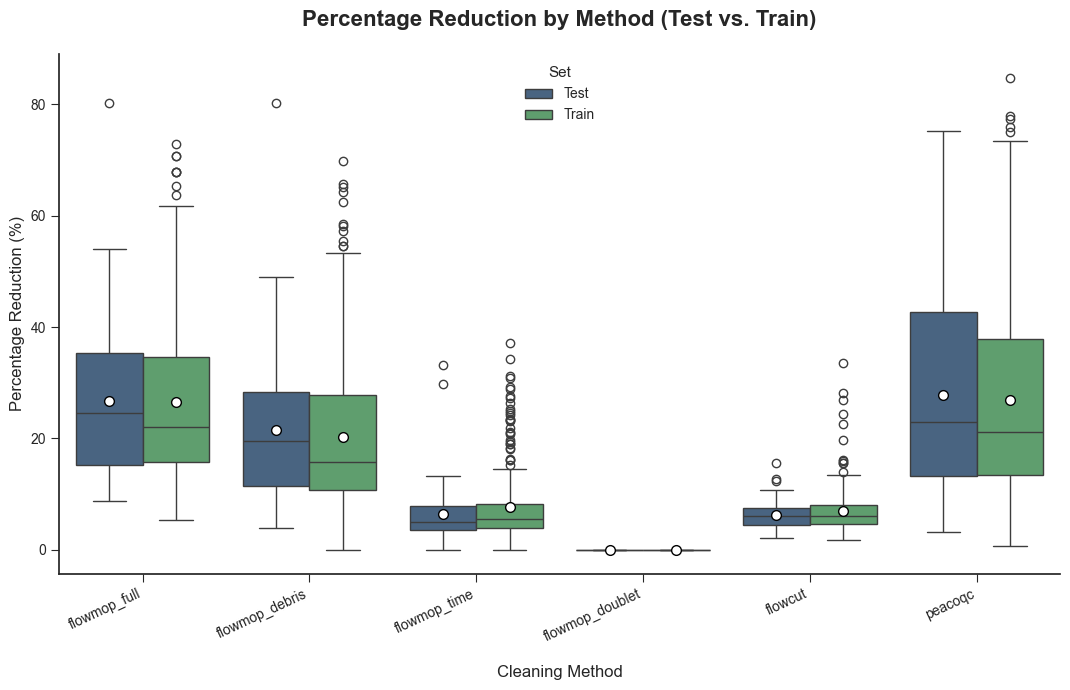

In [34]:
plot_percentage_reduction_with_stats(cleaning_summary)